In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_sequence(c_el, m_load, iter, previous_sequence, results_file, attempt, long_seq_pack):
    
    PLOT, PRINT = True, False

    # --------------------------------------------
    # If previous results were given (csv file)
    # --------------------------------------------
    
    if results_file != "":
    
        # Read the csv as a pandas dataframe
        df = pd.read_csv(results_file)
        
        if iter < len(df):
    
            # Read the corresponding sequence in the file
            sequence_string = df['sequence'][iter]
            sequence_file_dict = {}
            for i in range(1,9):
                combi = sequence_string[2+(i-1)*11:9+(i-1)*11].split(",")
                sequence_file_dict[f'combi{i}'] = [int(combi[0]), int(combi[1]), int(combi[2])]
            
            return sequence_file_dict
    
    # --------------------------------------------
    # For all attempts: get pre-maid sequence
    # --------------------------------------------
    
    # Get the hour of the day
    hour = iter%24
    
    # Initialize the sequence with all '2' (0=off, 1=on, 2=undetermined)
    sequence = 2*np.ones(len(c_el))

    # Depending on the type of load, the sequence will not be the same
    if round(np.mean(m_load),2) >= 0.10: load_type = "High load"
    elif round(np.mean(m_load),2) >= 0.05: load_type = "Medium load"
    else: load_type = "Low load"
    if PRINT: print(load_type)
        
    # For every hour in the next 24 hours
    for i in range(len(c_el)):

        # Always turn off the heat pump in high price periods
        if c_el[i] > 20: sequence[i] = 0

        # Always turn on the heat pump in negative price periods
        if c_el[i] < 0: sequence[i] = 1

        # Detect peaks, and their length
        if i<(len(c_el)-1) and abs(c_el[i+1] - c_el[i]) >= 15:
            if c_el[i+1] - c_el[i] > 0 and c_el[i+1]>20:
                length = i
                if PRINT: print(f"Price peak starting at {i+1}h")
            if c_el[i+1] - c_el[i] < 0  and c_el[i]>20:
                length = i - length
                if PRINT: print(f"Price peak finishing at {i+1}h, after {length} hours\n")

                # Depending on the load type, the minimum number of hours to charge before an x hour peak is not the same
                if load_type == "High load":
                    hours_charge = length
                elif load_type == "Medium load":
                    hours_charge = int(round(length/2 + 0.001)) if length>=2 else 1
                elif load_type == "Low load":
                    hours_charge = int(round(length/3 + 0.001)) if length>=3 else 1
                    # With low loads it might not be necessary to charge, leave undecided
                    # hours_charge = 0

                # Charge the tanks for as long as necessary before the peak
                for j in range(hours_charge):
                    # Hours that are still undefined are turned on
                    if sequence[i-length-j] == 2:
                        sequence[i-length-j] = 1
                    # Hours that were supposed to be turned off are turned on (this setting can change)
                    if sequence[i-length-j] == 0:
                        sequence[i-length-j] = 1
                        if hour < i-length+3-hours_charge:
                            print(f"\nNeed to charge more before peak {i+1-length}h-{i+1}h.")
                            print("Current setting is to use normally off periods to charge.")

    # Save the suggested sequence with 0=off, 1=on, 2=undetermined
    sequence012 = [int(x) for x in sequence[hour:hour+8]]
    
    # Get the indices of the hours with remaining undertermined state
    two_option_indices = [1 if x==2 else np.nan for x in sequence]

    # If the current hour is in an undetermined state, try running it with the HP off
    if sequence[hour] == 2: sequence[hour] = 0
        
    # All other undetermined hours are kept as on for now (as long as it is not their turn)
    sequence = [1 if x==2 else int(x) for x in sequence]

    if PLOT:
        
        # Split electricity price in past and future hours
        c_el_future = [np.nan]*(hour-1) + c_el[hour-1:] if hour>0 else [np.nan]*(hour) + c_el[hour:]
        c_el_past = c_el[:hour] + [np.nan]*(len(c_el)-hour)

        # Split sequence in past and future hours
        sequence_future = [np.nan]*(hour-1) + sequence[hour-1:] if hour>0 else [np.nan]*hour + sequence[hour:]
        sequence_past = sequence[:hour] + [np.nan]*(len(c_el)-hour)

        # Highlight hours with undetermined mode
        two_option_indices_plot = [np.nan]*hour + two_option_indices[hour:]

        # Duplicate the final element of each plotted list to extend it midnight
        c_el_future = c_el_future + [c_el_future[-1]]
        c_el_past = c_el_past + [c_el_past[-1]]
        sequence_future = sequence_future + [sequence_future[-1]]
        sequence_past = sequence_past + [sequence_past[-1]]
        two_option_indices_plot = two_option_indices_plot + [two_option_indices_plot[-1]]
        
        # Plot the past and future electricity prices and load
        fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True)
        ax.step(range(len(c_el)+1), c_el_future, where='post', alpha=0.4, color='black', linestyle='dashed')
        ax.step(range(len(c_el)+1), c_el_past, where='post', alpha=0.6, color='black')
        ax.set_xticks(range(len(c_el)+1))
        ax.set_xlim([-1,len(c_el)+1])
        ax.set_ylim([-10,45])
        ax2 = ax.twinx()
        ax2.step(range(len(c_el)+1), sequence_future, where='post', color='blue', alpha=0.6, linestyle='dashed')
        ax2.step(range(len(c_el)+1), sequence_past, where='post', color='blue', alpha=0.6)
        ax2.step(range(len(c_el)+1), two_option_indices_plot, where='post', color='red', alpha=0.9)
        ax2.set_yticks([0,1])
        ax2.set_ylim([-0.7,1.7])
        
        # Highlight the area corresponding to the horizon
        plt.axvline(x=hour, color='green', linestyle='dotted',alpha=0.2)
        plt.axvline(x=hour+8, color='green', linestyle='dotted',alpha=0.2)
        plt.axvspan(hour, hour+8, facecolor='green', alpha=0.05, label='Highlight')
        
        # Plot title
        plt.title(f"{load_type}") if two_option_indices[hour]!=1 else plt.title(f"{load_type} - two options")
        plt.show()

    # Trim the sequence to fit the 8-hour horizon
    sequence_trimmed = sequence[hour:hour+8]
    
    # Convert to combination format
    sequence_trimmed = [[1,1,1] if x==1 else [0,0,0] for x in sequence_trimmed]
    sequence_dict = {}
    for i in range(len(sequence_trimmed)):
        sequence_dict[f'combi{i+1}'] = sequence_trimmed[i]

    # Report if there are two options (current mode is undetermined)
    undetermined_now = two_option_indices[hour] == 1
    
    # Update the sequence with previous results
    #print("Previous sequence:\n", previous_sequence)
    #print("Current sequence before comparison:\n", sequence_dict)
    most_likely = {}
    for i in range(1,9): most_likely[f'combi{i}'] = []
    for i in range(1,8):
        if sequence_dict[f'combi{i}'] != previous_sequence[f'combi{i+1}']:
            if (sequence_dict[f'combi{i}'] == [0,0,0] and previous_sequence[f'combi{i+1}'] == [0,1,0]) \
            or (sequence_dict[f'combi{i}'] == [1,1,1] and previous_sequence[f'combi{i+1}'] == [1,0,1]):
                print(f"Replaced {sequence_dict[f'combi{i}']} by {previous_sequence[f'combi{i+1}']} in combi{i}")
                sequence_dict[f'combi{i}'] = previous_sequence[f'combi{i+1}']
                most_likely[f'combi{i}'] = previous_sequence[f'combi{i+1}']

    # --------------------------------------------
    # Attempt 1: use pre-maid sequence
    # Next attempts: adjust pre-maid sequence
    # Final attempts: run through all sequences
    # --------------------------------------------

    if PRINT: print("There are two options") if undetermined_now else print("Only one option")
    
    if load_type == "Low load":
        if attempt == 1:
            sequence_dict = long_sequence_check(iter, sequence012, long_seq_pack, c_el[hour:hour+8], m_load[hour:hour+8], most_likely)
        if attempt > 1:
            raise RuntimeError("No feasible sequence was found!")
        return sequence_dict
    
    if undetermined_now:
        if attempt == 2:
            sequence_dict['combi1'] = [0,1,0]
        if attempt == 3:
            sequence_dict['combi1'] = [1,1,1]
        if attempt == 4:
            sequence_dict = long_sequence_check(iter, sequence012, long_seq_pack, c_el[hour:hour+8], m_load[hour:hour+8], most_likely)
        if attempt > 4:
            raise RuntimeError("No feasible sequence was found!")
        return sequence_dict

    else:
        if attempt == 2:
            if sequence_dict['combi8'] != [0,0,0]: sequence_dict['combi8'] = [0,0,0]
            else: attempt += 1
        if attempt == 3:
            sequence_dict = long_sequence_check(iter, sequence012, long_seq_pack, c_el[hour:hour+8], m_load[hour:hour+8], most_likely)
        if attempt > 3:
            raise RuntimeError("No feasible sequence was found!")
        return sequence_dict

In [7]:
def long_sequence_check(iter, sequence012, long_seq_pack, elec_prices, loads, most_likely):
    print("Long sequence check")

The average load is 0.09 kg/s

Hour: 0


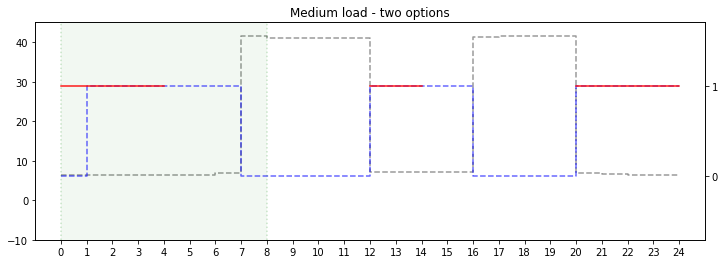

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


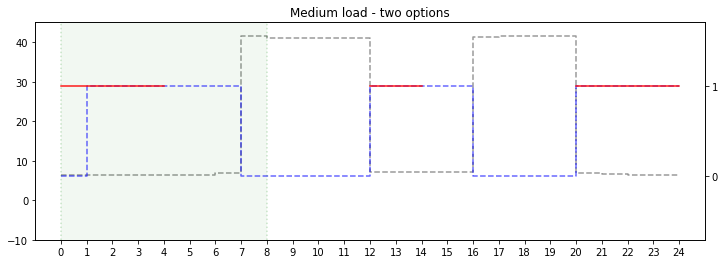

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


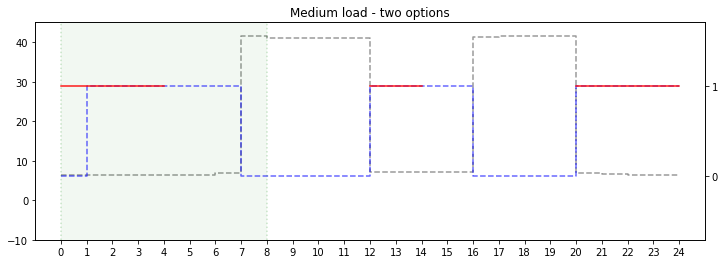

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}

Hour: 1


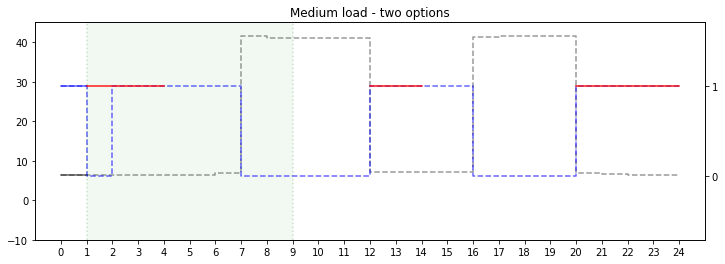

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


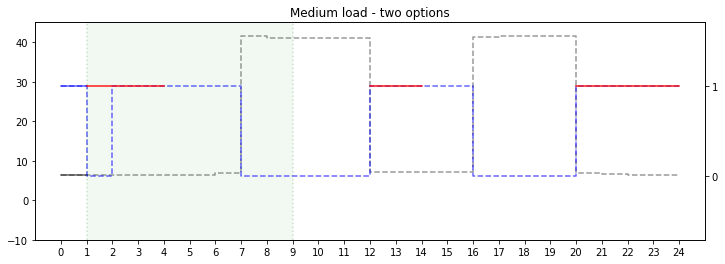

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


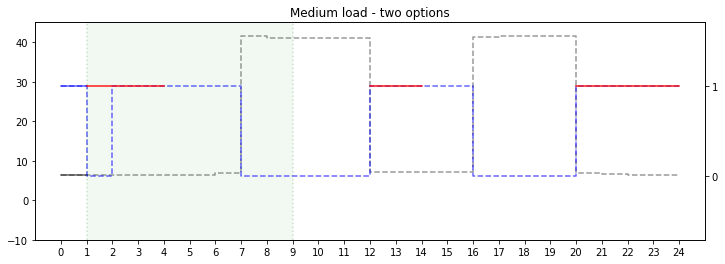

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}

Hour: 2


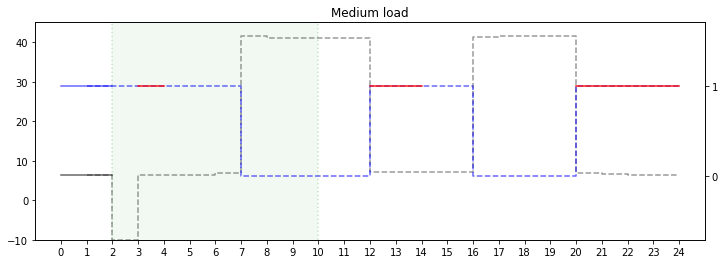

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


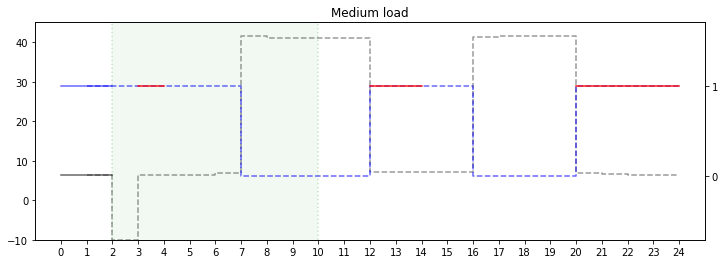

Long sequence check
None


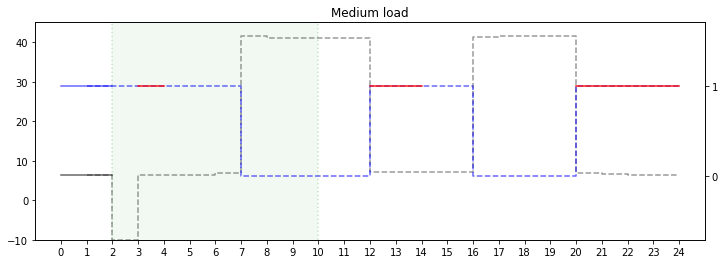

Long sequence check
None

Hour: 3


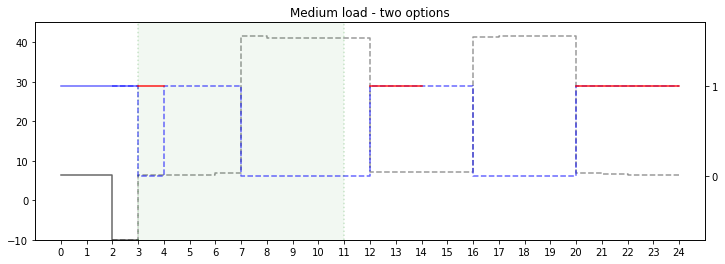

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


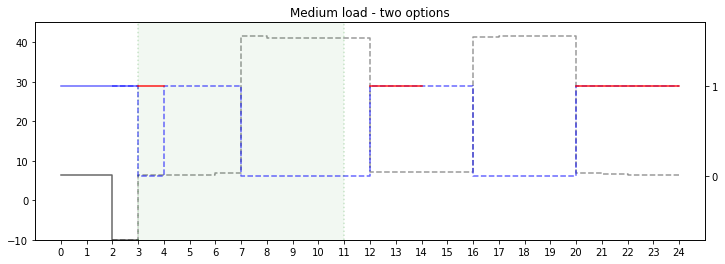

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


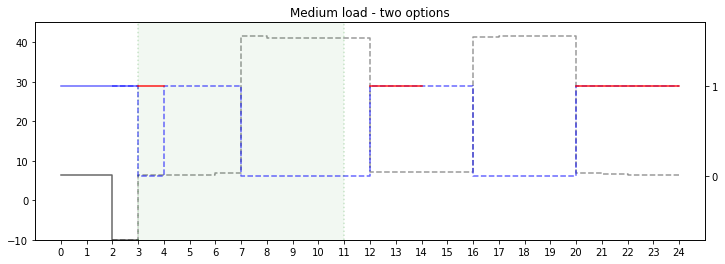

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}

Hour: 4


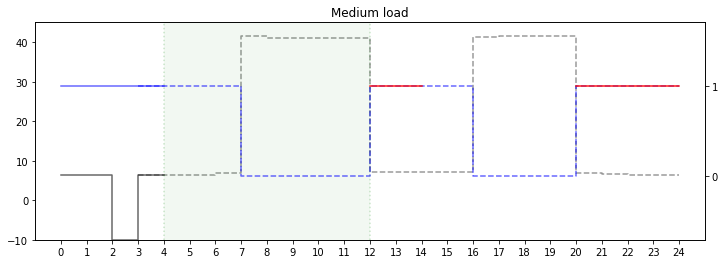

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


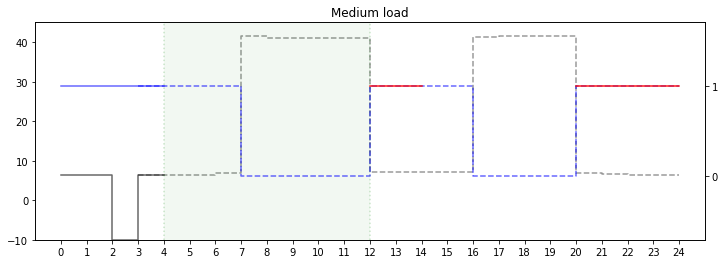

Long sequence check
None


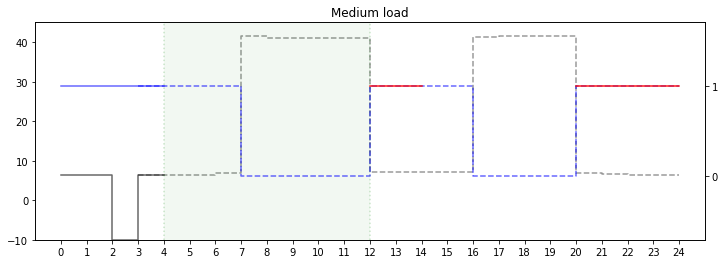

Long sequence check
None

Hour: 5


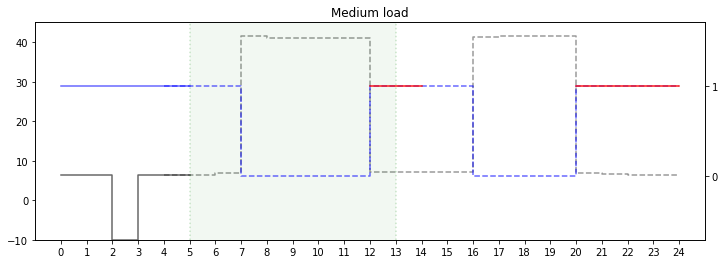

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [1, 1, 1]}


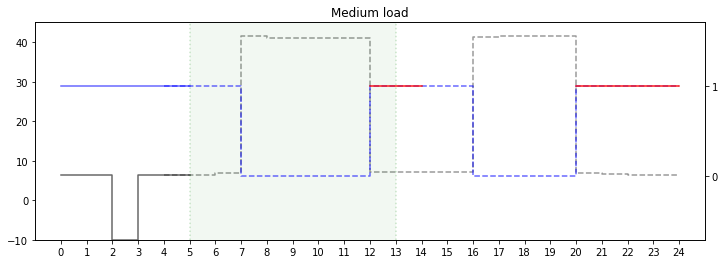

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


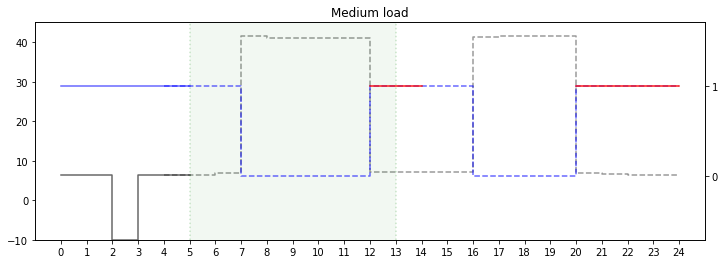

Long sequence check
None

Hour: 6


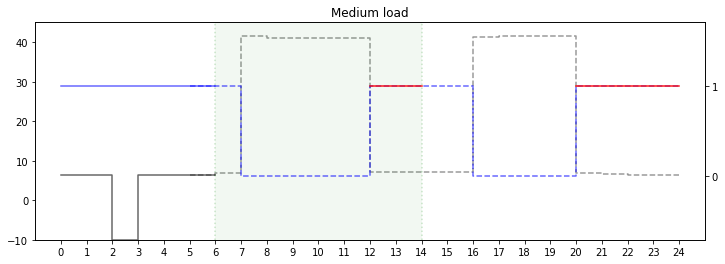

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


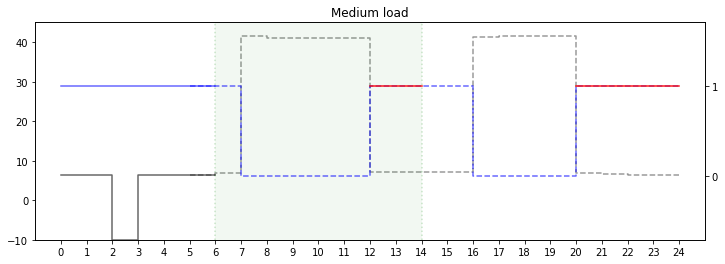

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


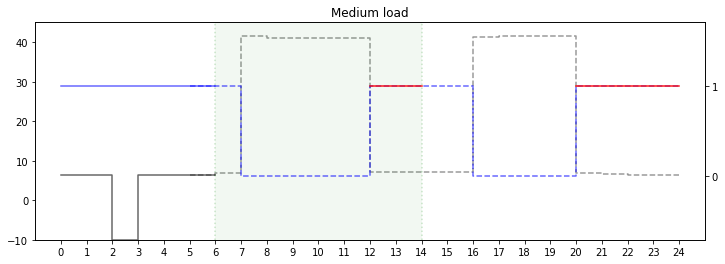

Long sequence check
None

Hour: 7


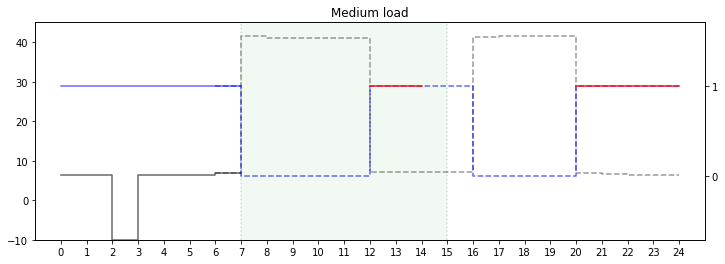

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


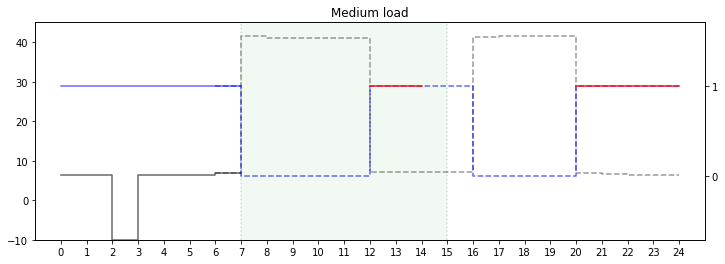

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


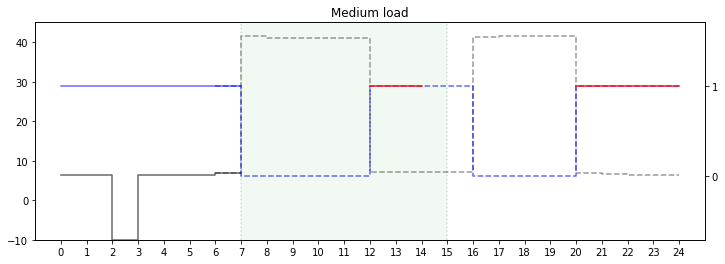

Long sequence check
None

Hour: 8


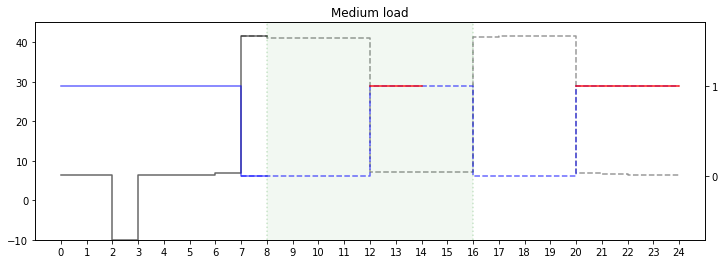

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


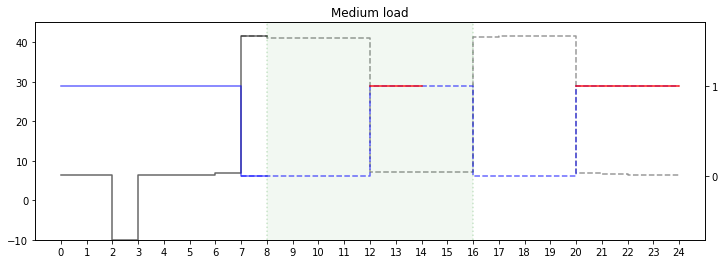

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


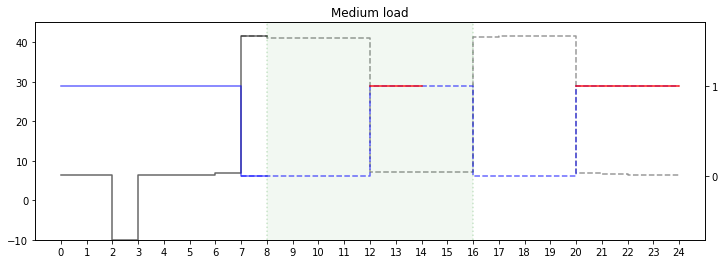

Long sequence check
None

Hour: 9


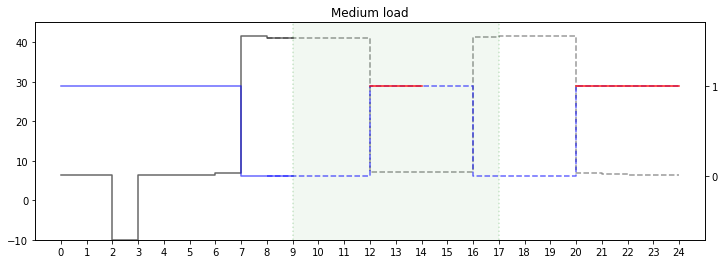

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


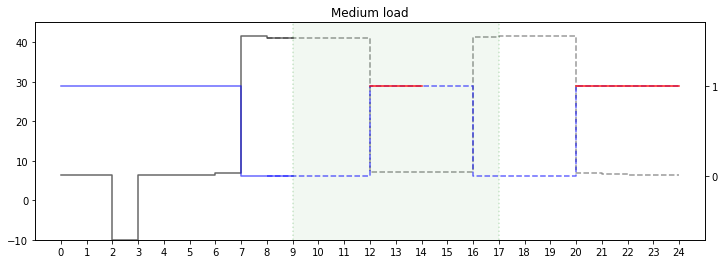

Long sequence check
None


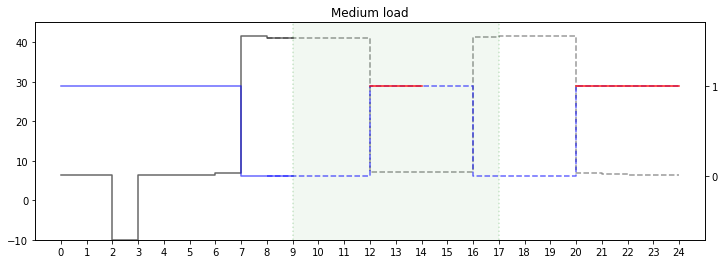

Long sequence check
None

Hour: 10


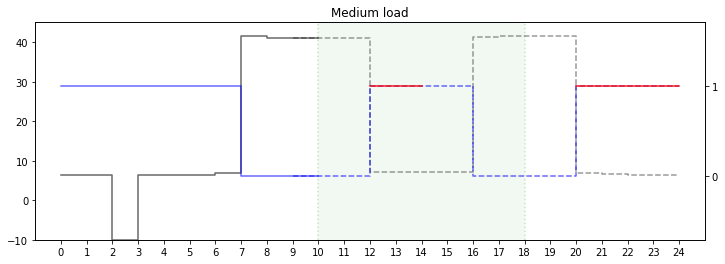

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


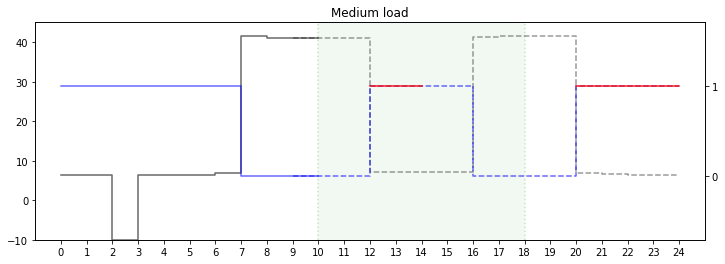

Long sequence check
None


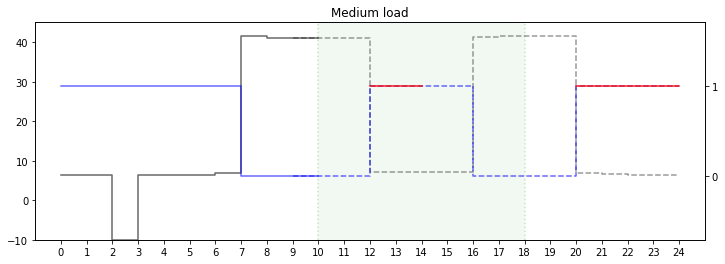

Long sequence check
None

Hour: 11


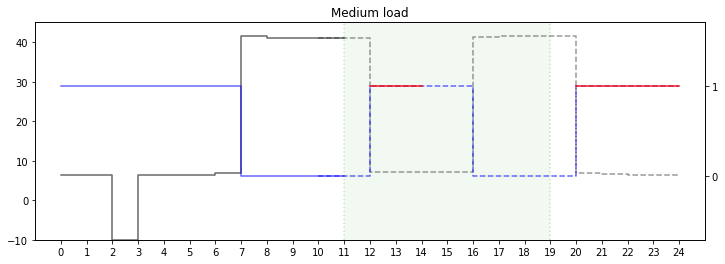

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


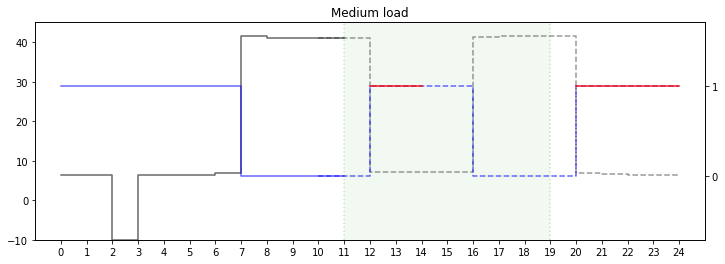

Long sequence check
None


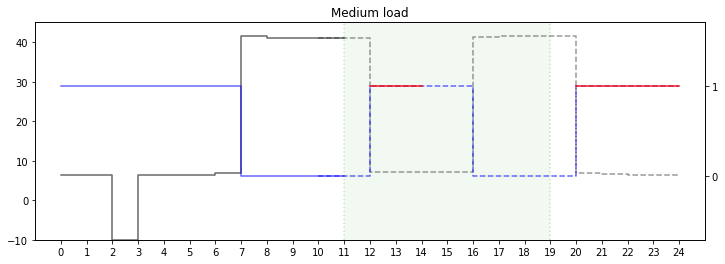

Long sequence check
None

Hour: 12


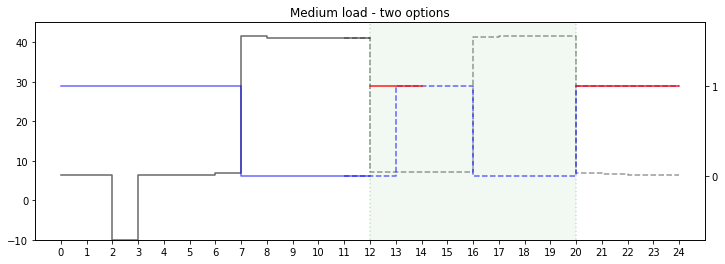

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


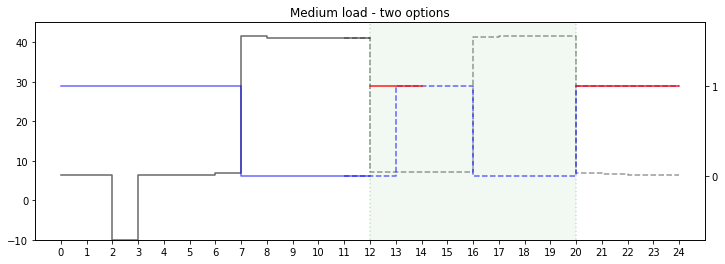

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


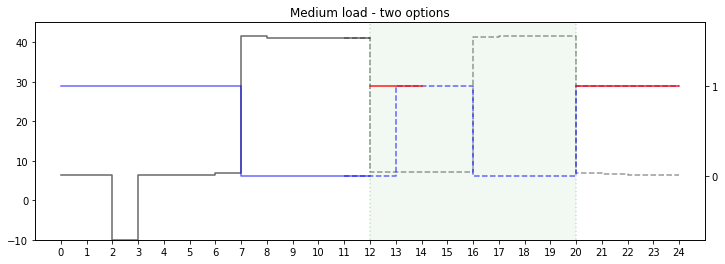

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}

Hour: 13


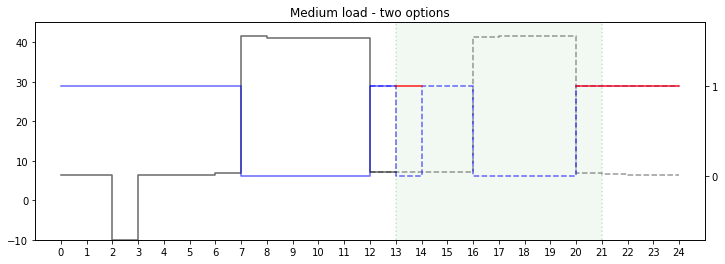

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [1, 1, 1]}


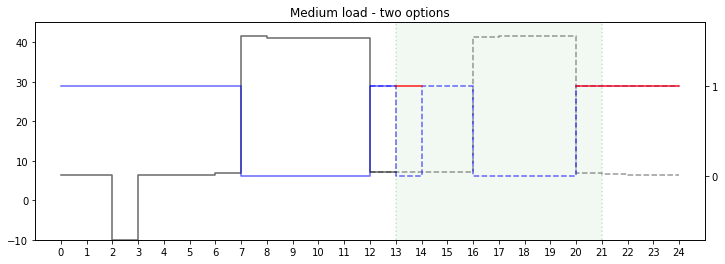

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [1, 1, 1]}


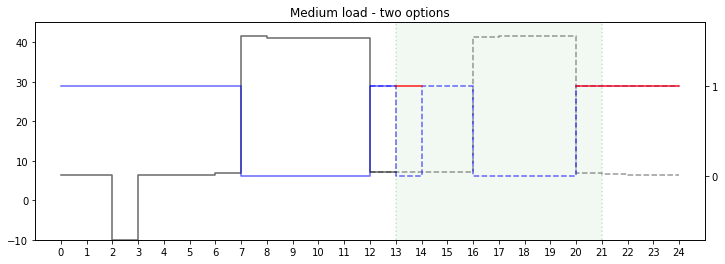

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [1, 1, 1]}

Hour: 14


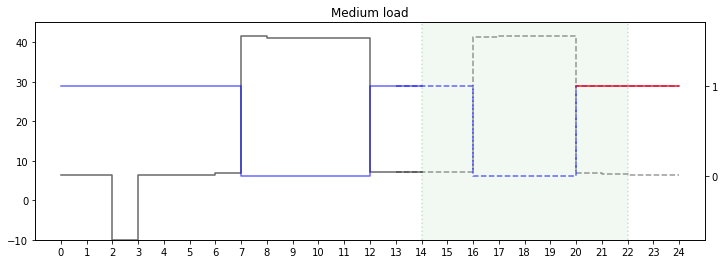

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


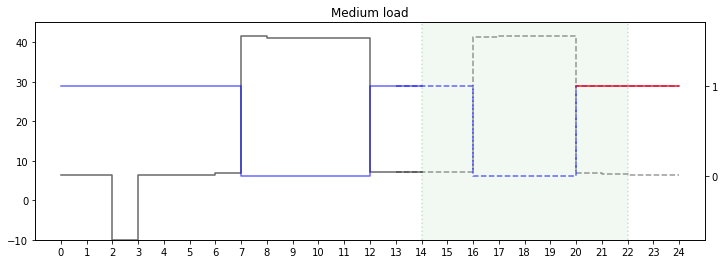

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


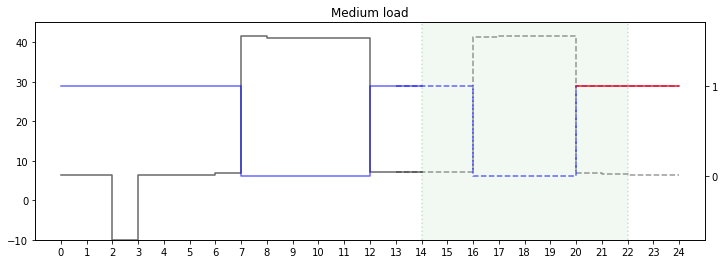

Long sequence check
None

Hour: 15


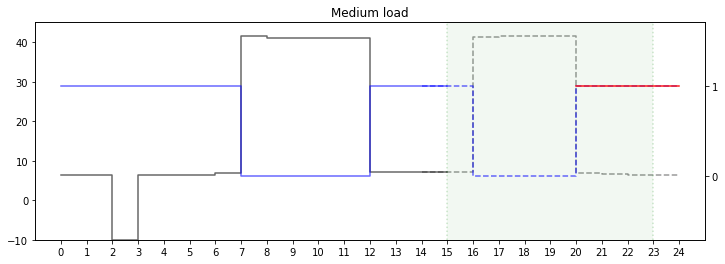

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


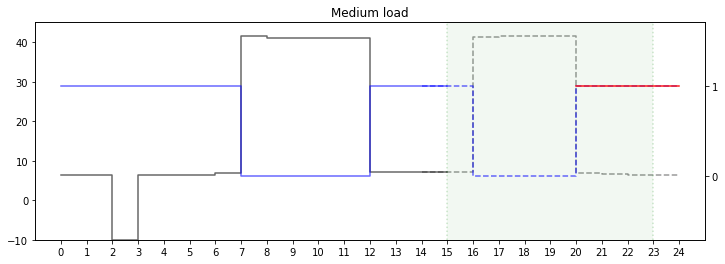

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


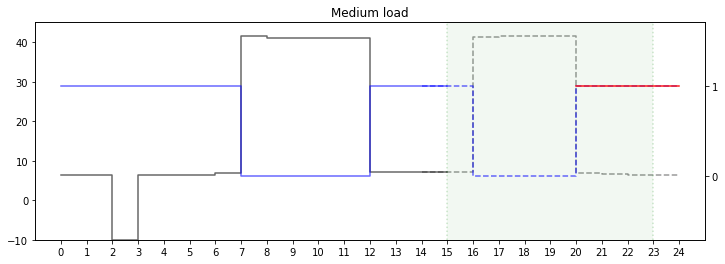

Long sequence check
None

Hour: 16


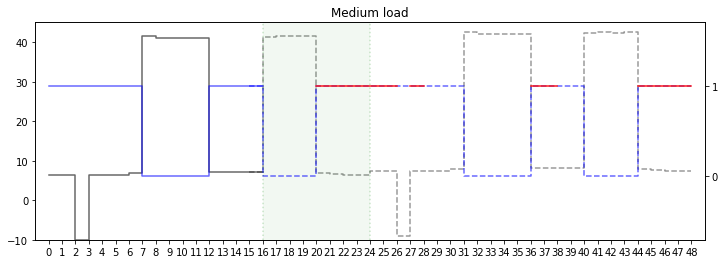

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


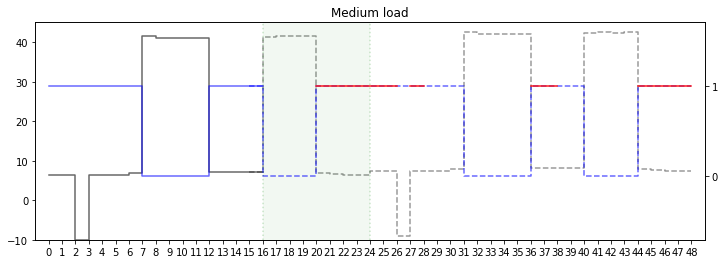

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


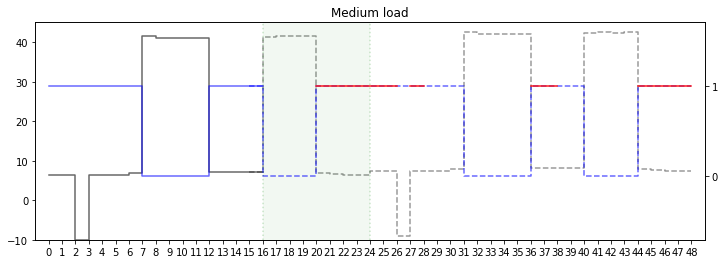

Long sequence check
None

Hour: 17


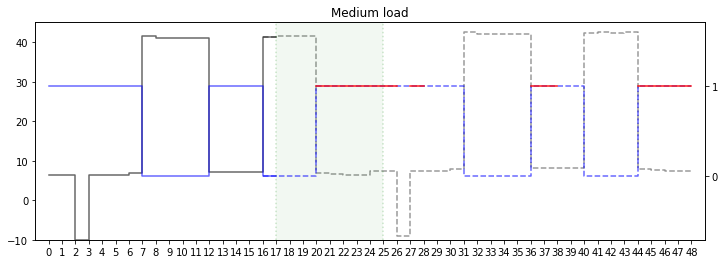

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


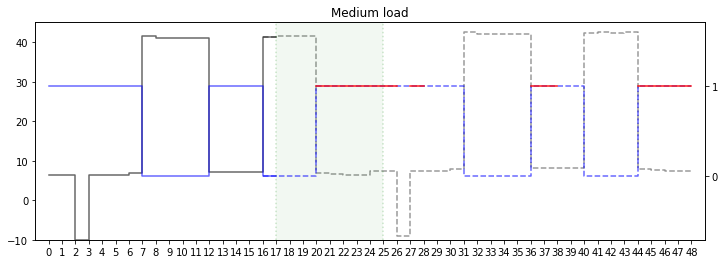

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


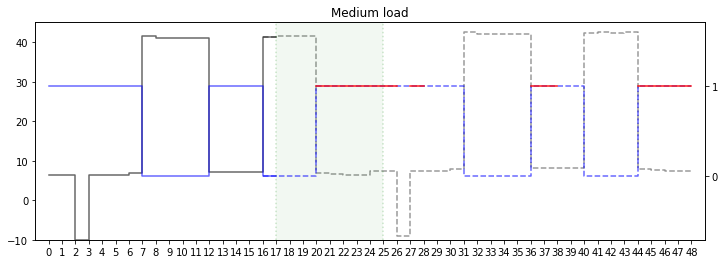

Long sequence check
None

Hour: 18


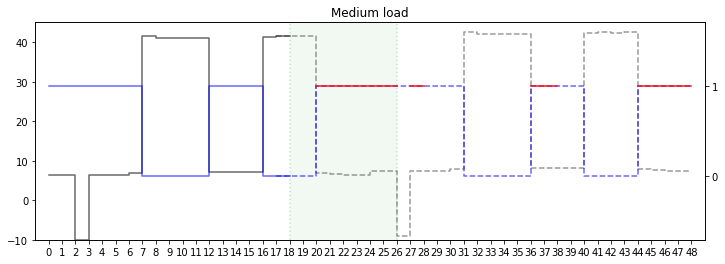

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


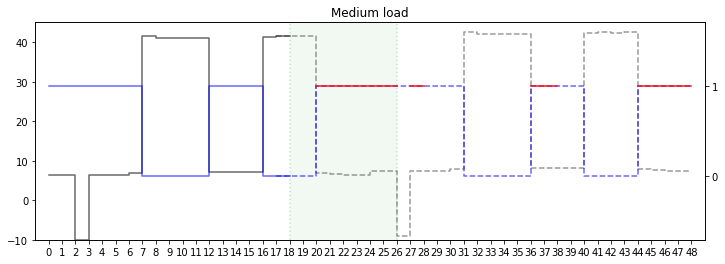

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


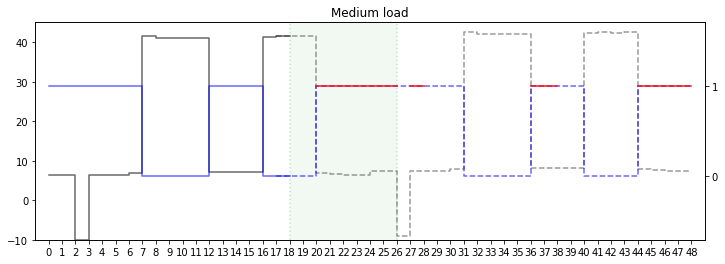

Long sequence check
None

Hour: 19


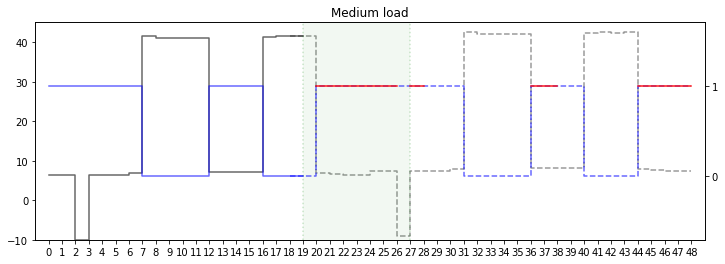

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


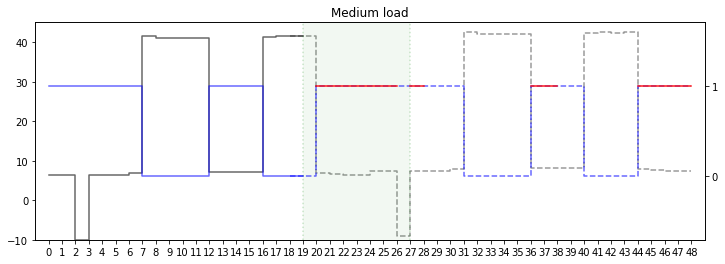

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


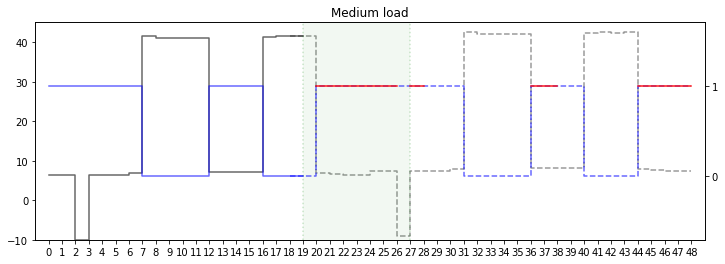

Long sequence check
None

Hour: 20


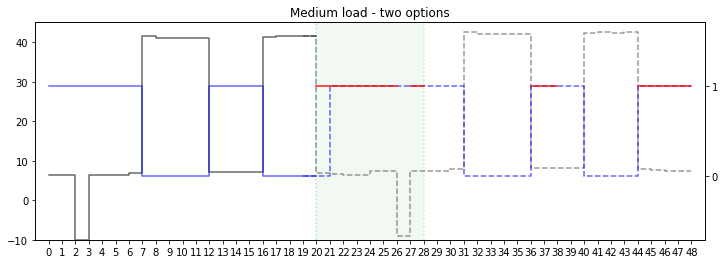

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


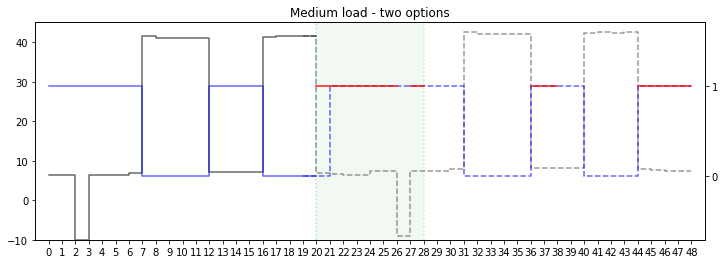

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


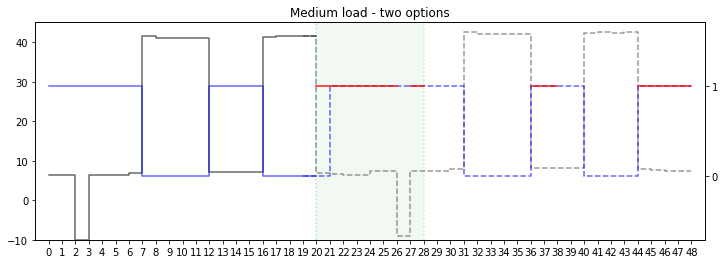

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}

Hour: 21


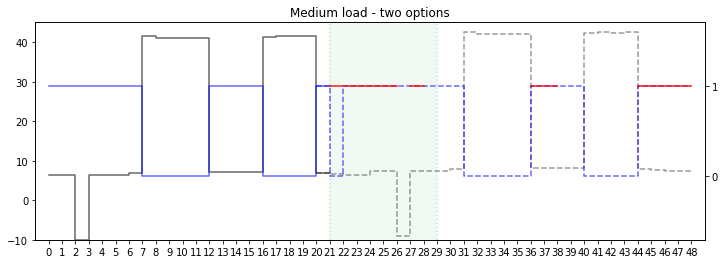

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


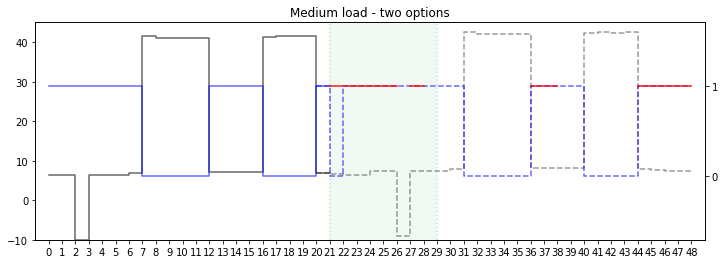

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


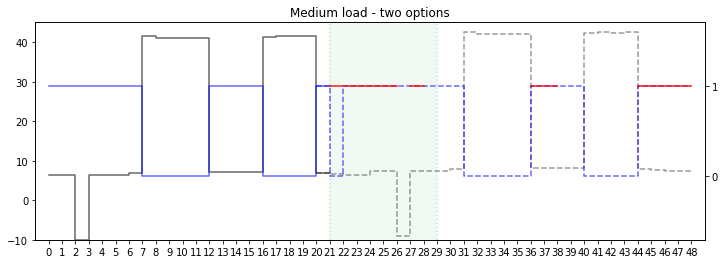

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}

Hour: 22


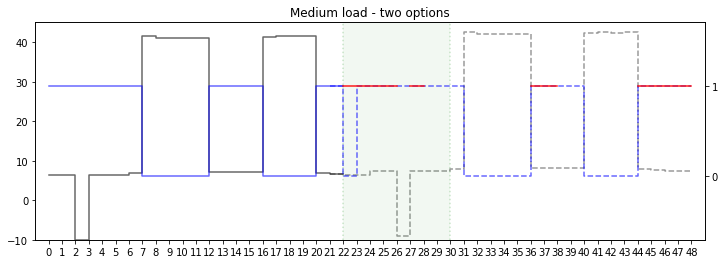

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


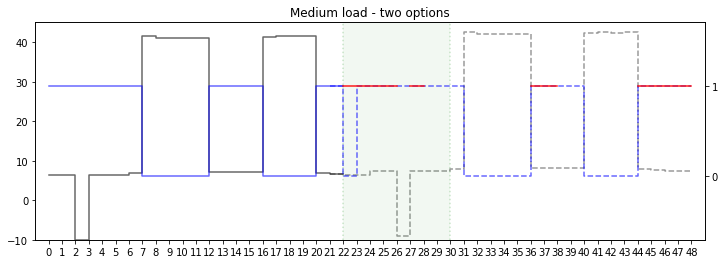

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


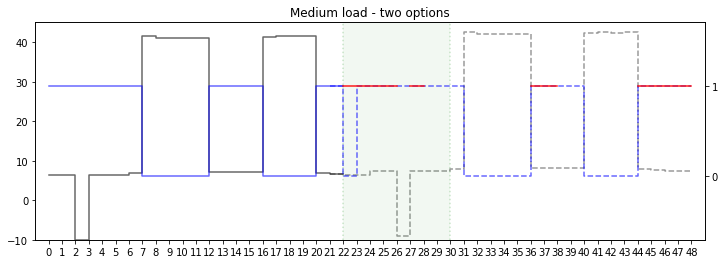

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}

Hour: 23


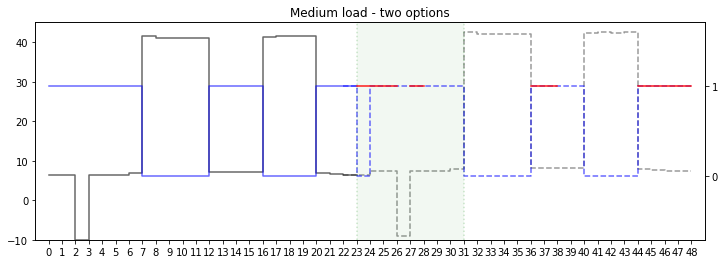

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


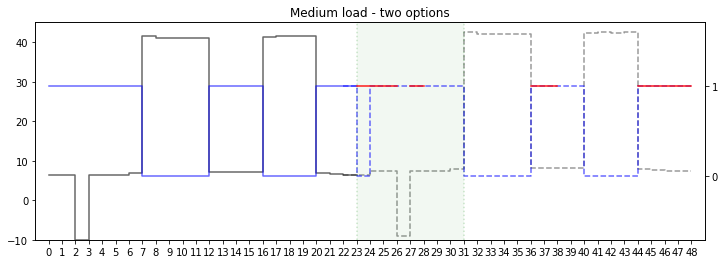

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


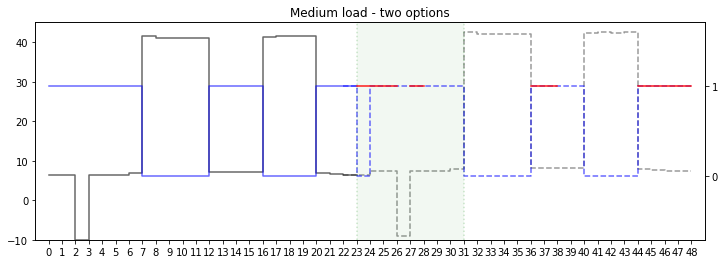

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}

Hour: 24


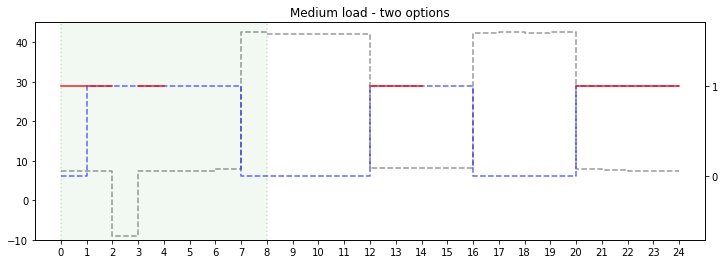

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


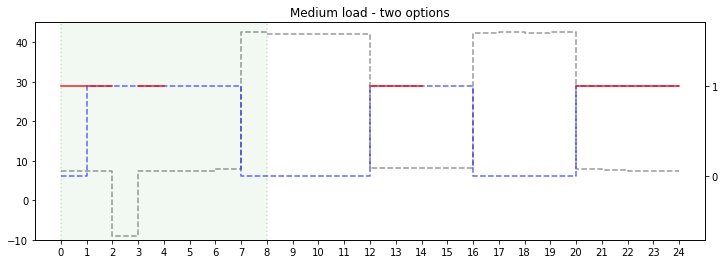

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


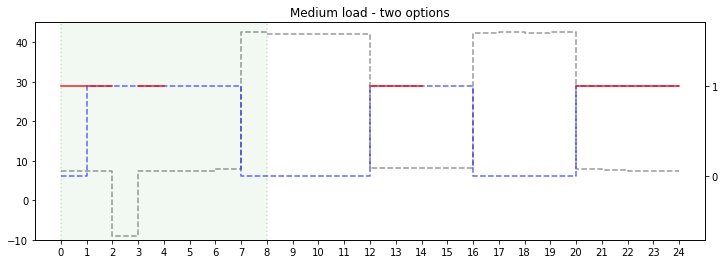

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}

Hour: 25


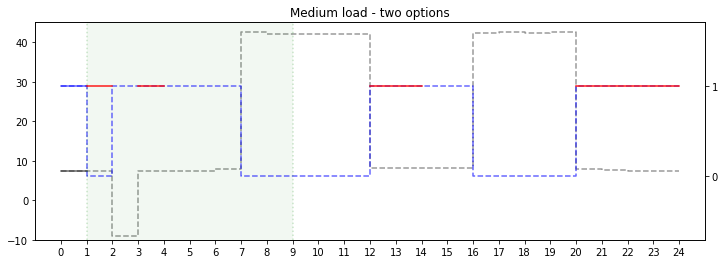

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


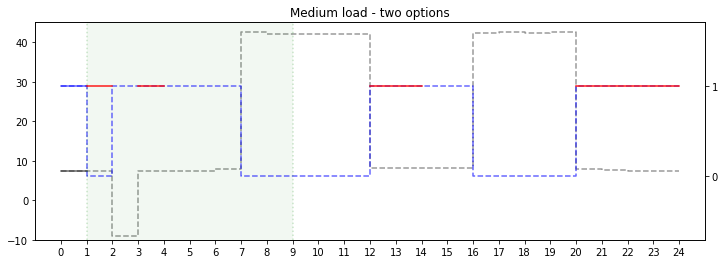

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


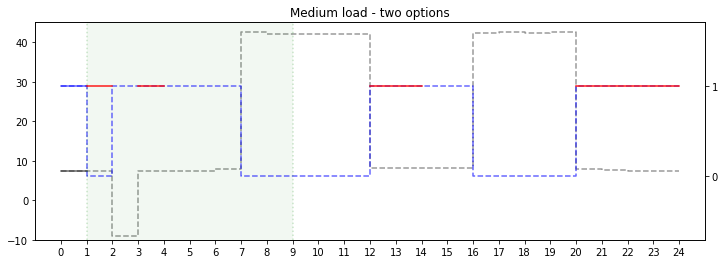

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}

Hour: 26


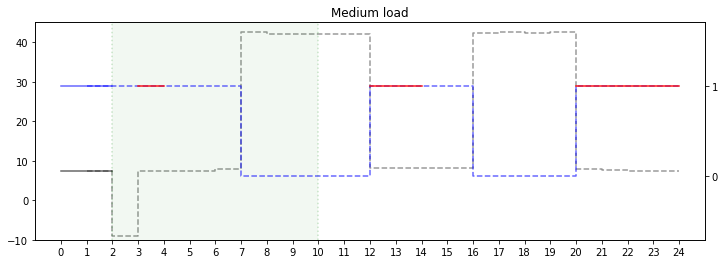

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


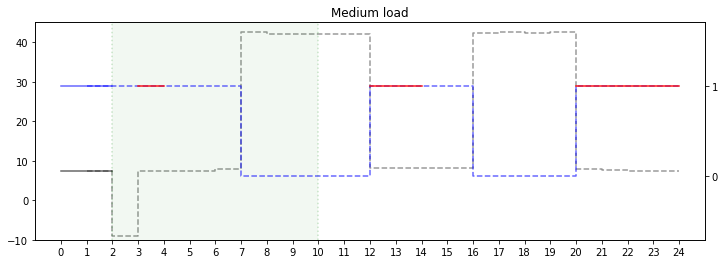

Long sequence check
None


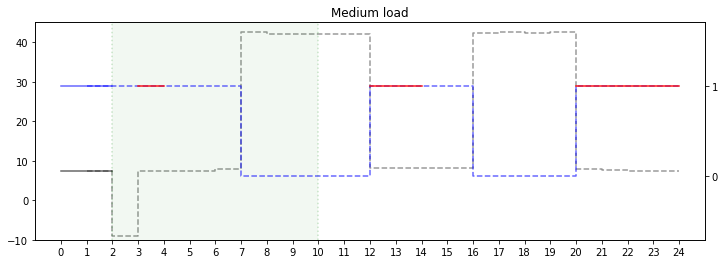

Long sequence check
None

Hour: 27


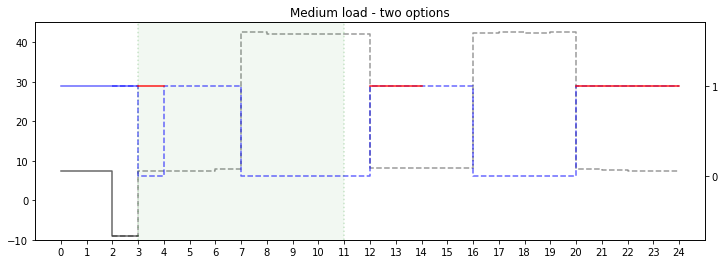

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


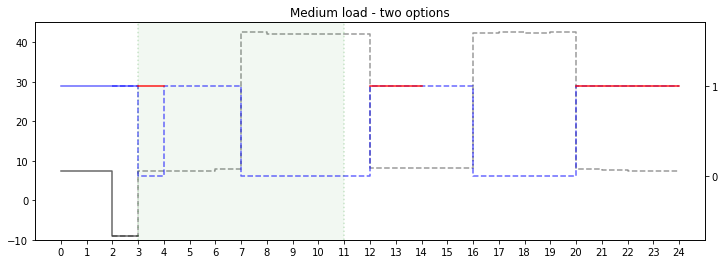

{'combi1': [0, 1, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


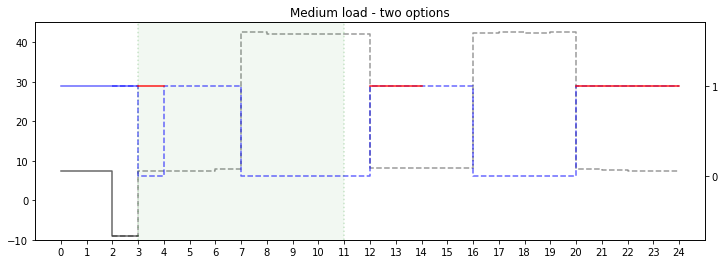

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}

Hour: 28


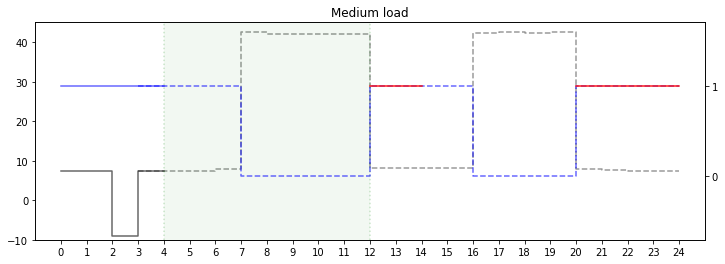

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


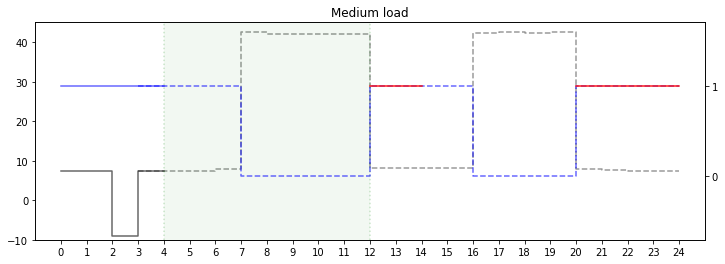

Long sequence check
None


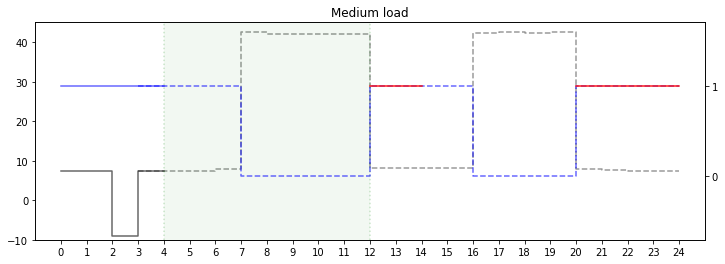

Long sequence check
None

Hour: 29


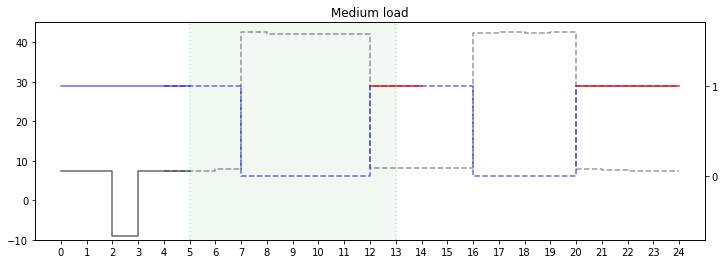

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [1, 1, 1]}


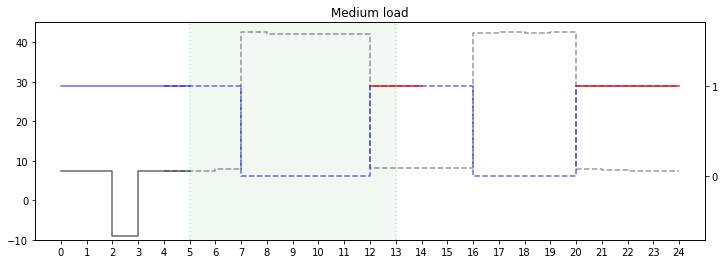

{'combi1': [1, 1, 1], 'combi2': [1, 1, 1], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


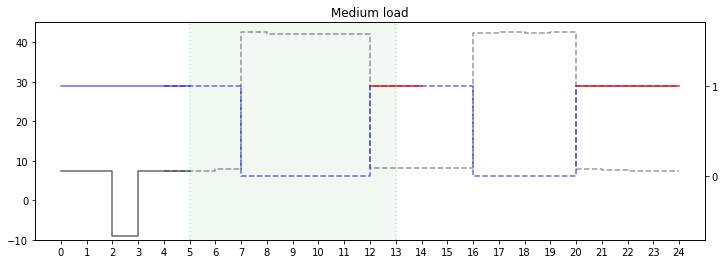

Long sequence check
None

Hour: 30


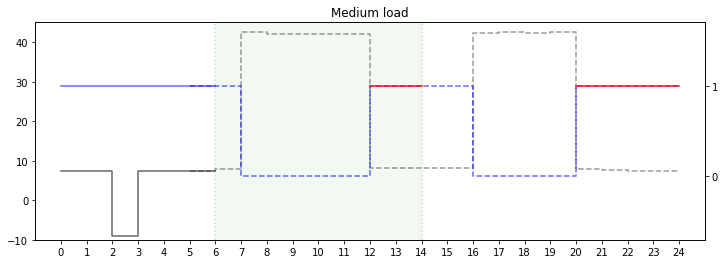

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


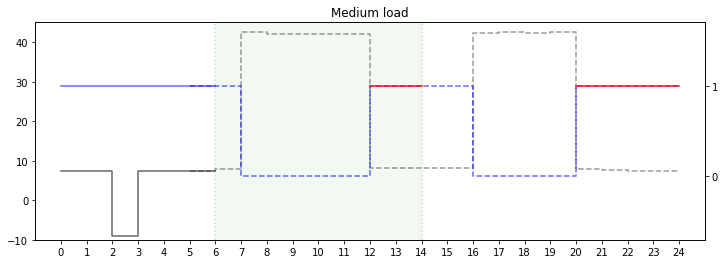

{'combi1': [1, 1, 1], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [0, 0, 0], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


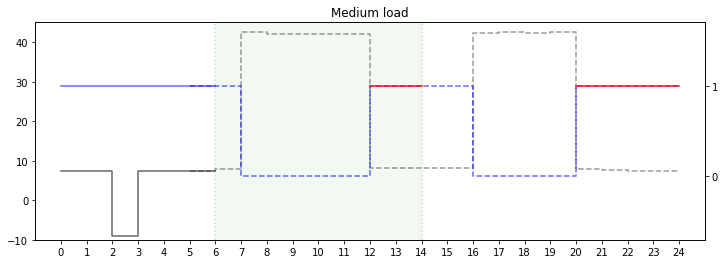

Long sequence check
None

Hour: 31


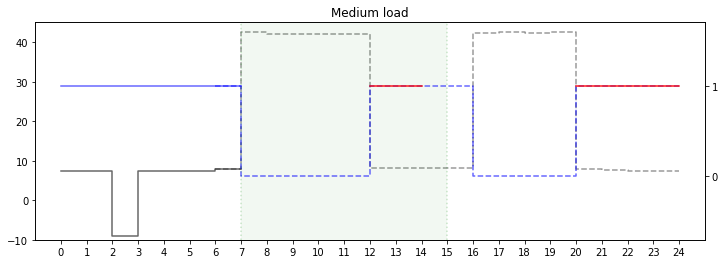

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


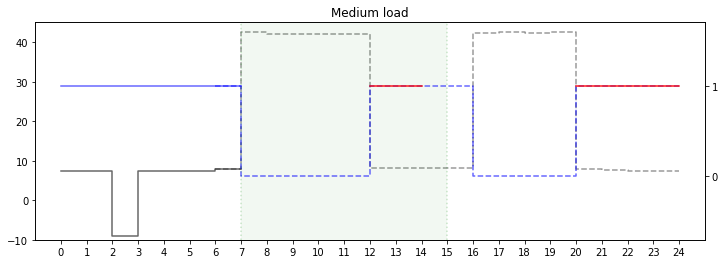

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [0, 0, 0], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


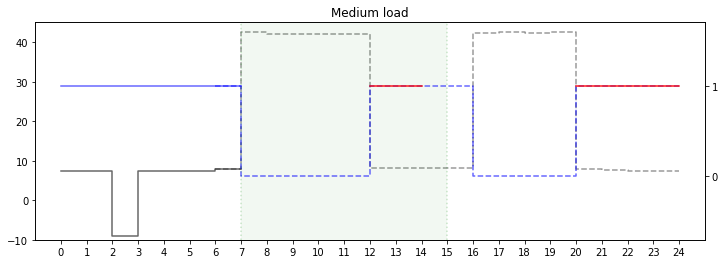

Long sequence check
None

Hour: 32


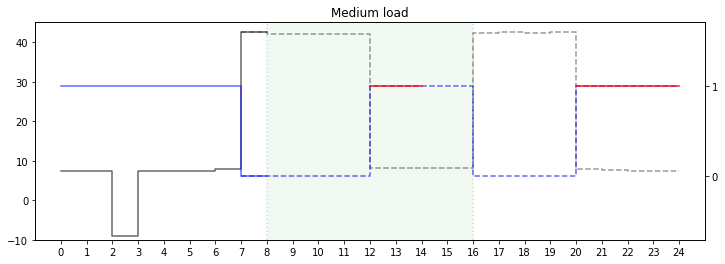

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [1, 1, 1]}


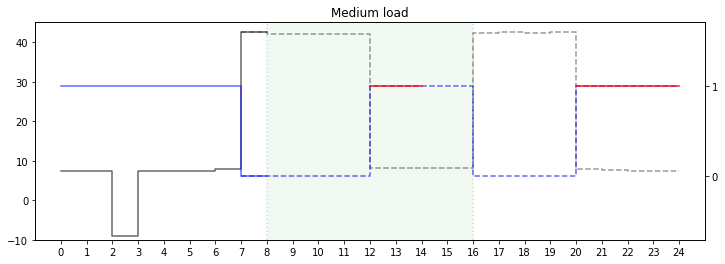

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [0, 0, 0], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


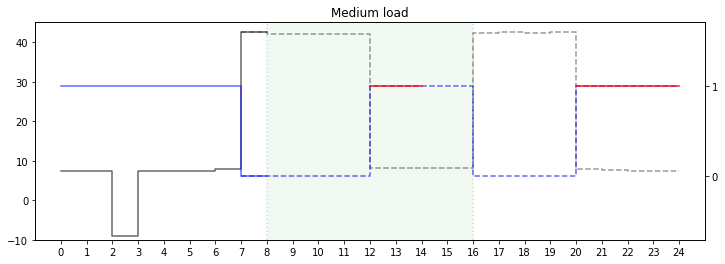

Long sequence check
None

Hour: 33


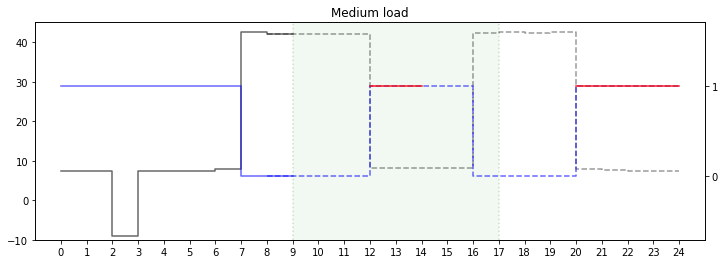

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [0, 0, 0], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [1, 1, 1], 'combi8': [0, 0, 0]}


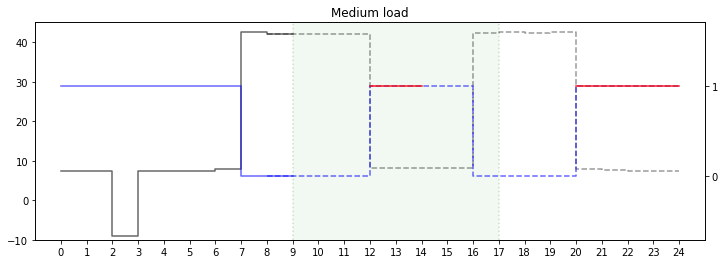

Long sequence check
None


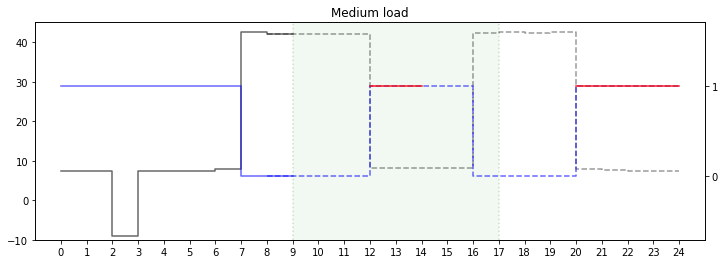

Long sequence check
None

Hour: 34


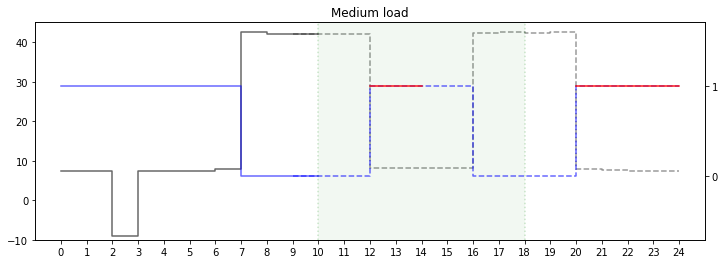

{'combi1': [0, 0, 0], 'combi2': [0, 0, 0], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [1, 1, 1], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


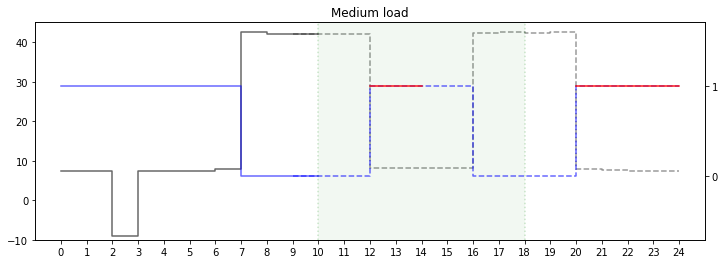

Long sequence check
None


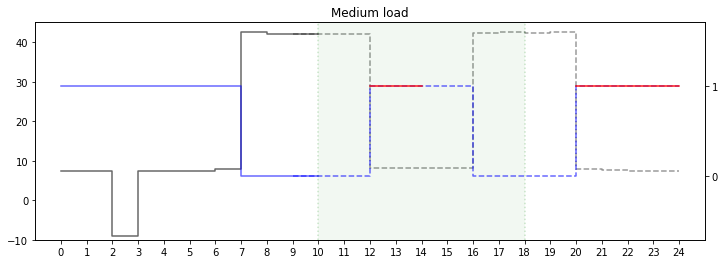

Long sequence check
None

Hour: 35


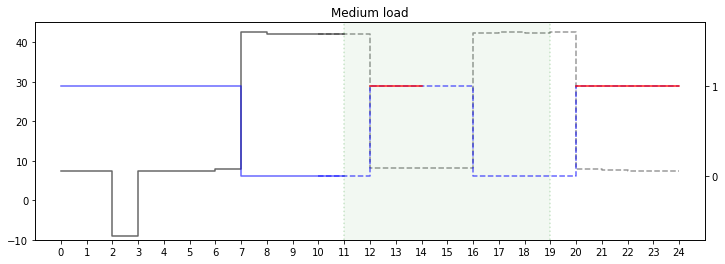

{'combi1': [0, 0, 0], 'combi2': [1, 1, 1], 'combi3': [1, 1, 1], 'combi4': [1, 1, 1], 'combi5': [1, 1, 1], 'combi6': [0, 0, 0], 'combi7': [0, 0, 0], 'combi8': [0, 0, 0]}


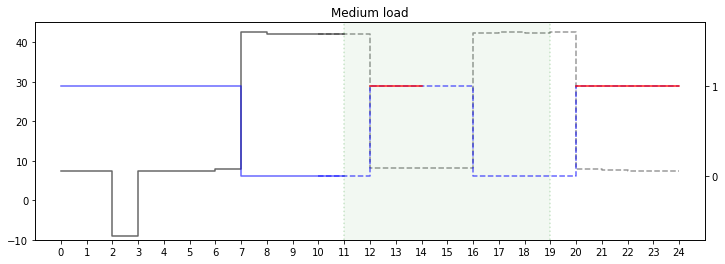

Long sequence check
None


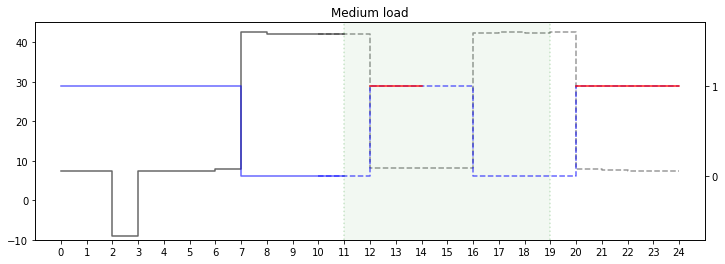

Long sequence check
None


In [8]:
num_iterations = 36
previous_sequence = {}
for i in range(8): previous_sequence[f'combi{i+1}'] = [1,1,1]
file_path = ""

for iter in range(num_iterations):
    
    # Get the first hourly forecasts
    if iter==0:
        c_el = [6.36, 6.34, 6.34, 6.37, 6.41, 6.46, 6.95, 41.51, 
                41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 
                41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4] 
        m_load = [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1, 
                  0.08, 0.08, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 
                  0.07, 0.07, 0.09, 0.09, 0.1, 0.1, 0.11, 0.11]
        print(f"The average load is {round(np.mean(m_load),2)} kg/s")
    
    # Get next day forecasts at 4:00 PM - TODO: replace with real forecasts
    if iter%24==16:
        c_el = c_el + [x+1 for x in c_el[:24]]
        m_load = m_load + m_load[:24]
        
    # At the start of a new day, crop forecasts
    if iter%24==0:
        c_el = c_el[-24:]
        m_load = m_load[-24:]

    # Negative price at 2AM
    if iter==2:
        c_el[2] = -10

    # As long as a feasible sequence is not found, try something new
    attempt = 1
    print(f"\nHour: {iter}")
    while attempt < 4:

        # Get a good sequence proposition (method depends on attempt)
        sequence = get_sequence(c_el, m_load, iter, previous_sequence, file_path, attempt, 0)
        print(sequence)
        
        # Next attempt
        attempt += 1
    
    # Save the working sequence for the next step
    #previous_sequence = sequence

In [ ]:
# Low load
m_load = [0.04, 0.04, 0.05, 0.05, 0.05, 0.04, 0.04, 0.03, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.03, 0.03, 0.04]
# Medium load
m_load = [0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1, 0.08, 0.08, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07, 0.09, 0.09, 0.1, 0.1, 0.11, 0.11]
# High load
m_load = [0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15]
# Scenario 1 - forecasts = reality
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
iter_eff = -1

for iter in range(24):
    for k in range(30):
        if iter==16+k*24: 
            c_el = c_el + c_el[:24]
        if iter==24+k*24: 
            c_el = c_el[:24]
            iter_eff=-1
    iter_eff+=1

    sequence = get_sequence(c_el, m_load, iter_eff)
    print(f"{iter}h: {sequence}\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_sequence(c_el, m_load, hour):

    PLOT, PRINT = True, False
    
    # Initialize the sequence with 2s (0=off, 1=on, 2=undetermined)
    sequence = 2*np.ones(len(c_el))

    # Depending on the type of load, the sequence will not be the same
    if round(np.mean(m_load),2) >= 0.10: load_type = "High load"
    elif round(np.mean(m_load),2) >= 0.05: load_type = "Medium load"
    else: load_type = "Low load"
    if PRINT: print(load_type)
        
    # For every hour in the next 24 hours
    for i in range(len(c_el)):

        # Always turn off the heat pump in high price periods
        if c_el[i] > 20: sequence[i] = 0

        # Always turn on the heat pump in negative price periods
        if c_el[i] < 0: sequence[i] = 1

        # Detect peaks, and their length
        if i<(len(c_el)-1) and abs(c_el[i+1] - c_el[i]) >= 15:
            if c_el[i+1] - c_el[i] > 0 and c_el[i+1]>20:
                length = i
                if PRINT: print(f"Price peak starting at {i+1}h")
            if c_el[i+1] - c_el[i] < 0  and c_el[i]>20:
                length = i - length
                if PRINT: print(f"Price peak finishing at {i+1}h, after {length} hours\n")

                # Depending on the load type, the minimum number of hours to charge before an x hour peak is not the same
                if load_type == "High load":
                    hours_charge = length
                elif load_type == "Medium load":
                    hours_charge = int(round(length/2 + 0.001)) if length>=2 else 1
                elif load_type == "Low load":
                    hours_charge = int(round(length/3 + 0.001)) if length>=3 else 1

                # Charge the tanks for as long as necessary before the peak
                for j in range(hours_charge):
                    # Hours that are still undefined are turned on
                    if sequence[i-length-j] == 2:
                        sequence[i-length-j] = 1
                    # Hours that were supposed to be turned off are turned on (this setting can change)
                    if sequence[i-length-j] == 0:
                        sequence[i-length-j] = 1
                        if hour < i-length+3-hours_charge:
                            print(f"\nNeed to charge more before peak {i+1-length}h-{i+1}h.")
                            print("Current setting is to use normally off periods to charge.")

    # Get the indices of the hours with remaining undertermined state
    two_option_indices = [1 if x==2 else np.nan for x in sequence]

    # If the current hour is in an undetermined state, try running it with the HP off
    if sequence[hour] == 2: sequence[hour] = 0
        
    # All other undetermined hours are kept as on for now (as long as it is not their turn)
    sequence = [1 if x==2 else int(x) for x in sequence]

    if PLOT:
        
        # Split electricity price in past and future hours
        c_el_future = [np.nan]*(hour-1) + c_el[hour-1:] if hour>0 else [np.nan]*(hour) + c_el[hour:]
        c_el_past = c_el[:hour] + [np.nan]*(len(c_el)-hour)

        # Split sequence in past and future hours
        sequence_future = [np.nan]*(hour-1) + sequence[hour-1:] if hour>0 else [np.nan]*hour + sequence[hour:]
        sequence_past = sequence[:hour] + [np.nan]*(len(c_el)-hour)

        # Highlight hours with undetermined mode
        two_option_indices_plot = [np.nan]*hour + two_option_indices[hour:]

        # Duplicate the final element of each plotted list to extend it midnight
        c_el_future = c_el_future + [c_el_future[-1]]
        c_el_past = c_el_past + [c_el_past[-1]]
        sequence_future = sequence_future + [sequence_future[-1]]
        sequence_past = sequence_past + [sequence_past[-1]]
        two_option_indices_plot = two_option_indices_plot + [two_option_indices_plot[-1]]
        
        # Plot the past and future electricity prices and load
        fig, ax = plt.subplots(1,1, figsize=(12,4), sharex=True)
        ax.step(range(len(c_el)+1), c_el_future, where='post', alpha=0.4, color='black', linestyle='dashed')
        ax.step(range(len(c_el)+1), c_el_past, where='post', alpha=0.6, color='black')
        ax.set_xticks(range(len(c_el)+1))
        ax.set_xlim([-1,len(c_el)+1])
        ax.set_ylim([-10,45])
        ax2 = ax.twinx()
        ax2.step(range(len(c_el)+1), sequence_future, where='post', color='blue', alpha=0.6, linestyle='dashed')
        ax2.step(range(len(c_el)+1), sequence_past, where='post', color='blue', alpha=0.6)
        ax2.step(range(len(c_el)+1), two_option_indices_plot, where='post', color='red', alpha=0.9)
        ax2.set_yticks([0,1])
        ax2.set_ylim([-0.7,1.7])
        
        # Highlight the area corresponding to the horizon
        plt.axvline(x=hour, color='green', linestyle='dotted',alpha=0.2)
        plt.axvline(x=hour+8, color='green', linestyle='dotted',alpha=0.2)
        plt.axvspan(hour, hour+8, facecolor='green', alpha=0.05, label='Highlight')
        
        # Plot title
        plt.title(f"{load_type}") if two_option_indices[hour]!=1 else plt.title(f"{load_type} - two options")
        plt.show()

    # Trim the sequence to fit the 8-hour horizon
    sequence_trimmed = sequence[hour:] + [1] * hour
    sequence_trimmed = sequence_trimmed[:8]

    # Check if yes or no there are two options
    undertermined_now = two_option_indices[hour] == 1

    return sequence_trimmed, undertermined_now

In [ ]:
# Scenario 2
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==9:
        c_el = [6.36, 6.34, 6.34, 6.41, 6.41, 6.46, 6.95, 41.51, 41.16, -5.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

In [ ]:
# Scenario 2
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

In [ ]:
# Scenario 3
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 41.2, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")

In [ ]:
# Scenario 4
c_el = [6.36, 6.34, 6.34, 6.4, 6.41, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
for iter in range(10):
    if iter==16:
        c_el = c_el + c_el
    if iter==3:
        c_el = [6.36, 6.34, 6.34, 6.41, 35, 6.46, 6.95, 41.51, 41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 41.2, -1.2, 41.64, 41.43, 41.51, 6.84, 6.65, 6.46, 6.4]
    sequence, two_options = get_sequence(c_el, m_load, iter)
    print(f"{iter}h: {sequence}, {two_options}\n")